In [214]:
from curses import KEY_DC
import math
import os
import glob
import numpy as np
from iou_3d import get_3d_box, box3d_iou
import pprint
from collections import namedtuple
import matplotlib.pyplot as plt

# Analsye deeply which part of the bad prediction hurt the performance
# Input : Label and Prediction in standard format
# Output : Graph, picture, data......

# TODO maybe we should do AP evaluation here to unify metric
INPUT_LABEL = "/data/datasets/KITTI3D/training/label_2/"

# DD3D
INPUT_PRIDT = "/home/lab530/KenYu/dd3d/outputs/2cyqwjvr-20220811_163826/inference/final-tta/kitti_3d_val/bbox3d_predictions_standard_format/"
# GAC
# INPUT_PRIDT = "/home/lab530/KenYu/visualDet3D/baseline_exp/Mono3D/output/validation/data/"
# Monoflex
# INPUT_PRIDT = "/home/lab530/KenYu/ml_toolkit/3d_object_detection_visualization/monoflex_prediction/"
# Psudeo lidar
# INPUT_PRIDT = "/home/lab530/KenYu/ml_toolkit/3d_object_detection_visualization/pseudo_lidar_prediction/"


# TODO don't care don't count as fp 
# TODO truck and car don't count as fp 
# TODO small object ??? check?
# TODO Different Threshold setting 
THRES = {"easy" : {"min_height": 40, "max_occlusion": 0, "max_truncation": 0.15}, 
         "modt" : {"min_height": 25, "max_occlusion": 1, "max_truncation": 0.3}, 
         "hard" : {"min_height": 25, "max_occlusion": 2, "max_truncation": 0.5}, 
}

N_PRIDT = len(os.listdir(INPUT_PRIDT))
Match = namedtuple('Match', ['idx', 'iou', 'conf'])
class Object:
    def __init__(self, str_line):
        # str_line should be 'Car 0.00 0 -1.58 587.19 178.91 603.38 191.75 1.26 1.60 3.56 -1.53 1.89 73.44 -1.60'
        sl = str_line.split()
        category = sl[0]
        truncated = float(sl[1]) # [0, 1]
        occluded = int(sl[2]) # (0, 1 ,2, 3)
        # 
        alpha = float(sl[3])
        x_min, y_min, x_max, y_max  = [float(i) for i in sl[4:8]]
        h, w, l = [float(i) for i in sl[8:11]]
        x_3d, y_3d, z_3d = [float(i) for i in sl[11:14]] # Center bottom of the object
        rot_y = float(sl[14])
        score = 1 # for labels
        if len(sl) == 16:
            score = float(sl[15]) # for prediction
        
        # Do some calculation 
        self.len_min_edge = min(x_max - x_min, y_max - y_min)
        self.area = (x_max - x_min) * (y_max - y_min)
        self.center_2d = ( (x_max + x_min)/2.0, (y_max + y_min)/2.0 )
        self.x_offset_from_pincipal_axis = abs(x_3d)
        self.euclidean_depth = math.sqrt((x_3d**2 + y_3d**2 + z_3d**2))
        
        # For AP_crit
        # Reference: https://arxiv.org/abs/2203.02205
        V_MAX = 20 # m/s
        D_max, R_max, T_max = 20, 15, 8 # This parameter setting is suggest by the paper on section D
        # (25, 5, 2)
        d_ego_b = math.sqrt((x_3d**2 + z_3d**2))
        vx, vz  = math.cos(-rot_y)*V_MAX, math.sin(-rot_y)*V_MAX
        vz -= V_MAX # Relative speed against ego
        # print(f"rot_y = {rot_y}")
        # print(f"vx, vz = {(vx, vz)}")

        # Line formular : Ax + Bz + C = 0
        A = vz / vx
        B = -1
        C = z_3d - A*x_3d
        closetp_x = -A*C / (A**2 + B**2)
        closetp_z = -B*C / (A**2 + B**2)

        if (closetp_x - x_3d) * (vx) > 0: # Same sign
            dt1 = (closetp_x - x_3d) / vx
            dt2 = (closetp_z - z_3d) / vz
            delta_t = dt1
            d_ego_c = abs(C) / math.sqrt(A**2 + B**2)
            # Don't know whether this will be a problem
            if abs(dt1 - dt2) > 1:
                print("[WARNING] dt1 dt2 is different, probably because x is too big")
        else: # ego and object are heading to differnet direction, so they won't collide in the future
            delta_t = float('inf')
            d_ego_c = float('inf')

        k_d = max(0, -(d_ego_b/D_max)**2 + 1)
        k_r = max(0, -(d_ego_c/R_max)**2 + 1)
        k_t = max(0, -(delta_t/T_max)**2 + 1)
        self.kappa = 1 - (1-k_d) * (1-k_r) * (1-k_t)
        # print(f"(k_d, k_r, k_t, kappa) = {(k_d, k_r, k_t, self.kappa)}")

        # Calculate 8 vertices
        self.x_min_3d = x_3d - l/2
        self.x_max_3d = x_3d + l/2
        self.y_min_3d = y_3d - h
        self.y_max_3d = y_3d
        self.z_min_3d = z_3d - w/2
        self.z_max_3d = z_3d + w/2
        # 
        self.match = {'bev': [], '3db': []} # [(idx, iou, conf), (idx, iou, conf)]
        # 
        self.category, self.truncated, self.occluded, self.alpha = category, truncated, occluded, alpha
        self.h, self.w, self.l = h, w, l
        self.x_min, self.y_min, self.x_max, self.y_max = x_min, y_min, x_max, y_max
        self.x_3d, self.y_3d, self.z_3d = x_3d, y_3d, z_3d
        self.rot_y, self.score = rot_y, score

## Find IOU

In [215]:
gts_all = []
pds_all = []
all_conf_thres = set()
for idx_path, path in enumerate(glob.glob(INPUT_PRIDT + "*.txt")):
    fn = path.split("/")[-1] # 003322.txt
    # if fn != "001051.txt" : continue
    # Get Ground True
    with open(INPUT_LABEL + fn, "r") as f:
        gt_lines = f.read().splitlines()
        gt_lines = list(gt_lines for gt_lines in gt_lines if gt_lines) # Delete empty lines
    gts = [Object(gt) for gt in gt_lines]
    
    # Get Predictions
    with open(INPUT_PRIDT + fn, "r") as f:
        pd_lines = f.read().splitlines()
        pd_lines = list(pd_lines for pd_lines in pd_lines if pd_lines) # Delete empty lines
    pds = [Object(pd) for pd in pd_lines]

    # Delete unwanted category
    gts_new = []
    for gt in gts:
        if gt.category == "Car": gts_new.append(gt)
    gts = gts_new
    # 
    pds_new = []
    for pd in pds:
        if pd.category == "Car": pds_new.append(pd)
    pds = pds_new
    
    # print(f"Number of ground trues: {len(gts)}")
    # print(f"Number of predictions: {len(pds)}")

    # Sort prediction by confident score
    pds = sorted(pds, key=lambda x: x.score, reverse=True)

    # Find max iou ground true match with prediction
    for pd_idx, pd in enumerate(pds):
        best_bev = (None, 0.0) # (gt_idx, iou)
        best_3db = (None, 0.0) # (gt_idx, iou)
        for gt_idx, gt in enumerate(gts):
            gt_corners = get_3d_box((gt.l, gt.w, gt.h), gt.rot_y, (gt.x_3d, gt.y_3d, gt.z_3d))
            pd_corners = get_3d_box((pd.l, pd.w, pd.h), pd.rot_y, (pd.x_3d, pd.y_3d, pd.z_3d))
            iou_3db, iou_bev = box3d_iou(gt_corners, pd_corners)
            if iou_bev > best_bev[1]:
                best_bev = (gt_idx, iou_bev)
            if iou_3db > best_3db[1]:
                best_3db = (gt_idx, iou_3db)
        
        # BEV
        if best_bev[0] != None:
            pds[pd_idx     ].match['bev'].append( Match(best_bev[0], best_bev[1], pd.score) )
            gts[best_bev[0]].match['bev'].append( Match(pd_idx,      best_bev[1], pd.score) )
        
        # 3DB
        if best_3db[0] != None:
            pds[pd_idx     ].match['3db'].append( Match(best_3db[0], best_3db[1], pd.score) )
            gts[best_3db[0]].match['3db'].append( Match(pd_idx,      best_3db[1], pd.score) )
        
        # Confident threshold
        all_conf_thres.add(pd.score)

    gts_all.extend(gts)
    pds_all.extend(pds)
    # Print progress
    if (idx_path+1) % 500 == 0:
        print(f"Processed {idx_path+1}/{N_PRIDT}")

# Confident threshold
all_conf_thres = sorted(list(all_conf_thres), reverse=False)

print(f"Number of total ground true: {len(gts_all)}")
print(f"Number of total detections: {len(pds_all)}")
print(f"Number of total different confident: {len(all_conf_thres)}")


Processed 500/3765
Processed 1000/3765
Processed 1500/3765
Processed 2000/3765
Processed 2500/3765
Processed 3000/3765
Processed 3500/3765
Number of total ground true: 14385
Number of total detections: 58925
Number of total different confident: 58841


## Calculate AP

In [216]:
from collections import defaultdict

MAX_N_CONF_THRES = 2000
# IOU_THRES_NAME = ['AP_50', 'AP_55', 'AP_60', 'AP_65', 'AP_70', 'AP_75', 'AP_80', 'AP_85', 'AP_90', 'AP_95']
# IOU_THRES      = [round(int(i.split("_")[-1])/100, 2) for i in IOU_THRES_NAME]
IOU_THRES_NAME = ['AP_50', 'AP_70']
IOU_THRES      = [0.5    , 0.7    ]
rp = {'bev': defaultdict(list),
      '3db': defaultdict(list),
      'bev_crit': defaultdict(list),
      '3db_crit': defaultdict(list),} # [{'AP_50': [(recall, precision), (), .....], 'AP_55', .....}]

# Reduce number of total confident score in order to save time
print(f"Number of different confident: {len(all_conf_thres)}")
if len(all_conf_thres) > MAX_N_CONF_THRES:
    new_idx = np.round(np.linspace(0, len(all_conf_thres) - 1, MAX_N_CONF_THRES)).astype(int)
    all_conf_thres = [all_conf_thres[new_i] for new_i in new_idx]
all_conf_thres = [0] + all_conf_thres + [1.0]
#
print(f"Number of total groundtrue: {len(gts_all)}")
print(f"Number of total prediction: {len(pds_all)}")
print(f"Number of reduced confidents: {len(all_conf_thres)}")
# 
for type in ['bev', '3db']:
    for iou_idx, iou_thres in enumerate(IOU_THRES):
        for conf_thres in all_conf_thres: # enumerate(np.arange(0, 1+1/N_CONF_THRES, 1/N_CONF_THRES)) :
            # Get tp, fn ,fp 
            tp, fn, fp = 0, 0, 0
            tp_gt_crit, tp_pd_crit, fn_gt_crit, fp_pd_crit = 0, 0, 0, 0
            for gt in gts_all:
                is_find = False
                for match in gt.match[type]:
                    if match.conf > conf_thres:
                        if is_find is False and match.iou > iou_thres:
                            tp += 1
                            tp_gt_crit += gt.kappa
                            tp_pd_crit += pds_all[match[0]].kappa
                            is_find = True # One ground true could only have one positive
                        else:
                            fp += 1
                            fp_pd_crit += pds_all[match[0]].kappa
                if not is_find:
                    fn += 1
                    fn_gt_crit += gt.kappa
            
            # Recall and Precision 
            try:
                rp[type][IOU_THRES_NAME[iou_idx]].append( (tp/(tp+fn), tp/(tp+fp)) )
            except ZeroDivisionError:
                pass
            try:
                percision_safe = tp_gt_crit / (tp_pd_crit + fp_pd_crit)
                recall_safe    = tp_pd_crit / (tp_gt_crit + fn_gt_crit)
                # print(f"(p, r) = {(tp/(tp+fn), tp/(tp+fp))}")
                # print(f"(percision_safe, recall_safe) = {(percision_safe, recall_safe)}")
                rp[type+"_crit"][IOU_THRES_NAME[iou_idx]].append( (recall_safe, percision_safe) )
            except ZeroDivisionError:
                pass
            # print(f"(tp, fn, fp) = {(tp, fn, fp)}")
            assert tp + fn == len(gts_all), "Something weird happned, tp + fn != number of ground true !!"

        rp[type][IOU_THRES_NAME[iou_idx]] = sorted(rp[type][IOU_THRES_NAME[iou_idx]], key=lambda x: x[0])
        print(f"Finish Calculate {type} RP_Curve under IOU = {iou_thres}")
        rp[type+"_crit"][IOU_THRES_NAME[iou_idx]] = sorted(rp[type+"_crit"][IOU_THRES_NAME[iou_idx]], key=lambda x: x[0])
        print(f"Finish Calculate {type}_crit RP_Curve under IOU = {iou_thres}")
    print(f"Number of rp point = {len(rp[type]['AP_50'])}")


Number of different confident: 58841
Number of total groundtrue: 14385
Number of total prediction: 58925
Number of reduced confidents: 2002
Finish Calculate bev RP_Curve under IOU = 0.5
Finish Calculate bev_crit RP_Curve under IOU = 0.5
Finish Calculate bev RP_Curve under IOU = 0.7
Finish Calculate bev_crit RP_Curve under IOU = 0.7
Number of rp point = 2000
Finish Calculate 3db RP_Curve under IOU = 0.5
Finish Calculate 3db_crit RP_Curve under IOU = 0.5
Finish Calculate 3db RP_Curve under IOU = 0.7
Finish Calculate 3db_crit RP_Curve under IOU = 0.7
Number of rp point = 2000


## Plot AP

============ bev evaluation ============
AP_50 = 0.4909
AP_70 = 0.2125
============ 3db evaluation ============
AP_50 = 0.4351
AP_70 = 0.1382
============ bev_crit evaluation ============
AP_50 = 0.4907
AP_70 = 0.2176
============ 3db_crit evaluation ============
AP_50 = 0.438
AP_70 = 0.135


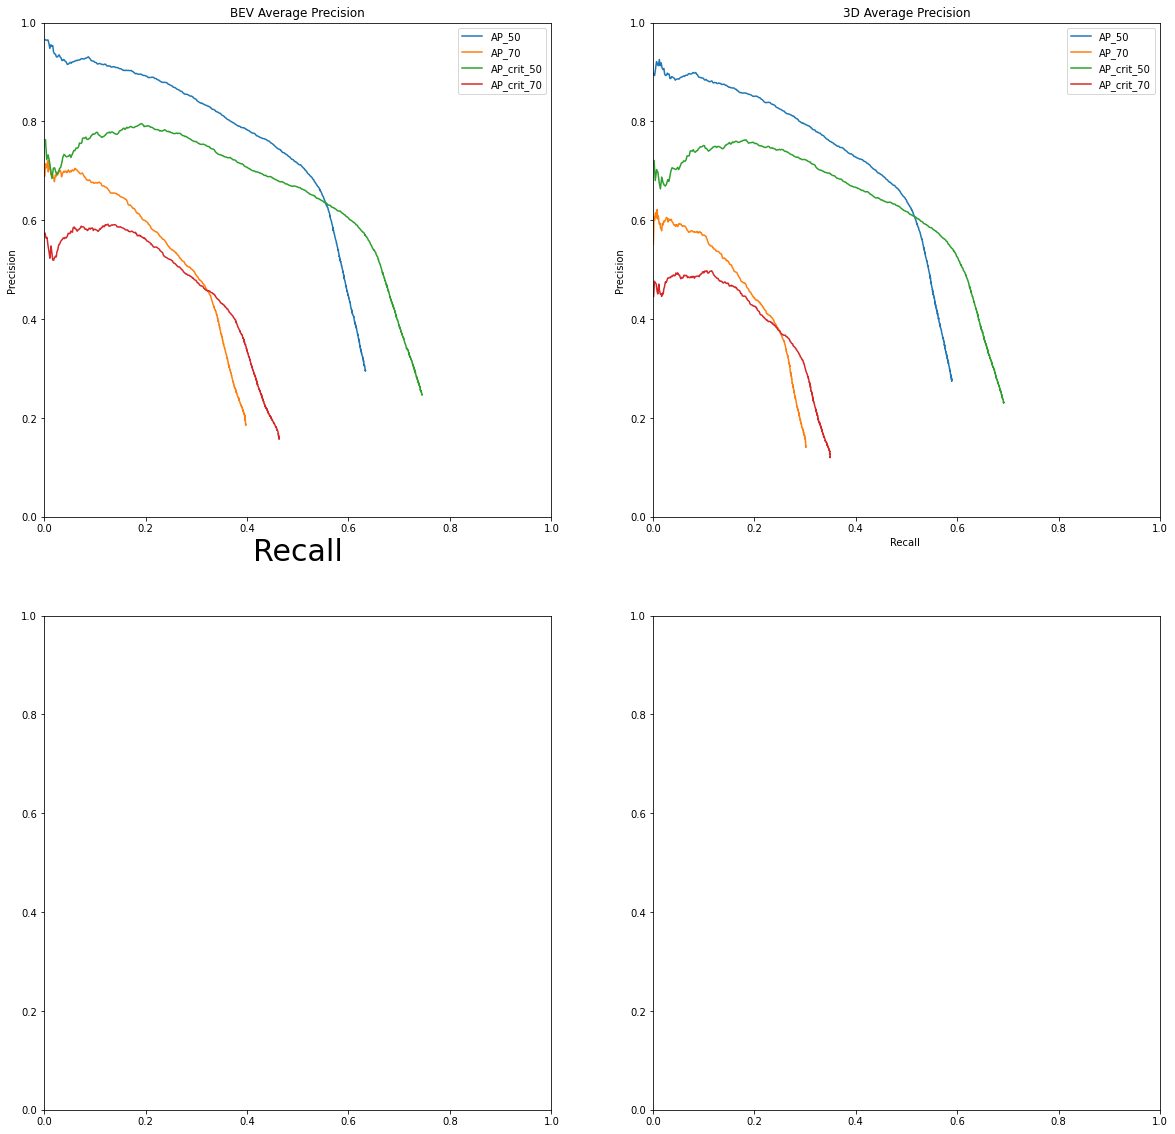

In [224]:
# 11-point scheme, recall = [0, 0.1, 0.2, ... 1.0] # Use by KITTI, before  08.10.2019
# 40-point scheme, recall = [1/40, 2/40, 3/40, .... 40/40] # KITTI improved version (Suggested by MonoDIS)

for type in rp.keys():
    print(f"============ {type} evaluation ============")
    for ap_name in rp[type]:
        ap = 0
        # for recall in np.arange(0, 1.1, 0.1): 11-point scheme
        for recall in np.arange(1/40, 41/40, 1/40): # 40-point scheme
            for rp_point in rp[type][ap_name]:
                if rp_point[0] >= recall:
                    ap += rp_point[1] / 40
                    # print(f"sample AP curve point : {rp_point}")
                    break
        print(f"{ap_name} = {round(ap, 4)}")

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
# plotting the points
ax[0, 0].plot([i[0] for i in rp['bev']["AP_50"] ], [i[1] for i in rp['bev']["AP_50"] ], label='AP_50')
ax[0, 0].plot([i[0] for i in rp['bev']["AP_70"] ], [i[1] for i in rp['bev']["AP_70"] ], label='AP_70')
ax[0, 0].plot([i[0] for i in rp['bev_crit']["AP_50"] ], [i[1] for i in rp['bev_crit']["AP_50"] ], label='AP_crit_50')
ax[0, 0].plot([i[0] for i in rp['bev_crit']["AP_70"] ], [i[1] for i in rp['bev_crit']["AP_70"] ], label='AP_crit_70')
ax[0, 0].set_xlim([0, 1.0])
ax[0, 0].set_ylim([0, 1.0])
ax[0, 0].set_xlabel('Recall', fontsize=30)
ax[0, 0].set_ylabel('Precision', fontsize=30)
ax[0, 0].set_title('BEV Average Precision', fontsize=40)
ax[0, 0].legend()
#
ax[0, 1].plot([i[0] for i in rp['3db']["AP_50"] ], [i[1] for i in rp['3db']["AP_50"] ], label='AP_50')
ax[0, 1].plot([i[0] for i in rp['3db']["AP_70"] ], [i[1] for i in rp['3db']["AP_70"] ], label='AP_70')
ax[0, 1].plot([i[0] for i in rp['3db_crit']["AP_50"] ], [i[1] for i in rp['3db_crit']["AP_50"] ], label='AP_crit_50')
ax[0, 1].plot([i[0] for i in rp['3db_crit']["AP_70"] ], [i[1] for i in rp['3db_crit']["AP_70"] ], label='AP_crit_70')
ax[0, 1].set_xlim([0, 1.0])
ax[0, 1].set_ylim([0, 1.0])
ax[0, 1].set_xlabel('Recall ', fontsize=30)
ax[0, 1].set_ylabel('Precision ', fontsize=30)
ax[0, 1].set_title('3D Average Precision', fontsize=40)
ax[0, 1].legend()

## Calcuate AR rate

In [218]:
x3d_bucket = np.array([-40, -30, -20, -10, 0, 10, 20, 30, 40]) # m
x3d_values = [{'tp':0, 'fn':0, 'fp':0} for _ in range(len(x3d_bucket))]
# 
z3d_bucket = np.array([5, 15, 25, 35, 45, 55, 65, 75]) # m
z3d_values = [{'tp':0, 'fn':0, 'fp':0} for _ in range(len(z3d_bucket))]
# 
area_bucket = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) # pixel
area_values = [{'tp':0, 'fn':0, 'fp':0} for _ in range(len(area_bucket))]

for gt in gts_all:
    # TODO maybe i should check whether there's candidate predication that has higher IOU
    # Leads to confidence error
    if len(gt.match['bev']) != 0 and gt.match['bev'][0][1] > IOU_THRES[0]: # Positive
        x3d_values[(np.abs(x3d_bucket - gt.x_3d)).argmin()]['tp'] += 1
        z3d_values[(np.abs(z3d_bucket - gt.z_3d)).argmin()]['tp'] += 1
        area_values[(np.abs(area_bucket - gt.area)).argmin()]['tp'] += 1
    else:
        x3d_values[(np.abs(x3d_bucket - gt.x_3d)).argmin()]['fn'] += 1
        z3d_values[(np.abs(z3d_bucket - gt.z_3d)).argmin()]['fn'] += 1
        area_values[(np.abs(area_bucket - gt.area)).argmin()]['fn'] += 1

x3d_values = [d['tp']/(d['tp'] + d['fn']) if d['tp'] + d['fn'] != 0 else 0 for d in x3d_values]
z3d_values = [d['tp']/(d['tp'] + d['fn']) if d['tp'] + d['fn'] != 0 else 0 for d in z3d_values]
area_values = [d['tp']/(d['tp'] + d['fn']) if d['tp'] + d['fn'] != 0 else 0 for d in area_values]

print("x_3d")
print(x3d_bucket)
print(x3d_values)
print("z_3d")
print(z3d_bucket)
print(z3d_values)
print("area_values")
print(area_bucket)
print(area_values)


x_3d
[-40 -30 -20 -10   0  10  20  30  40]
[0.0, 0.1702127659574468, 0.28097731239092494, 0.4750785810507409, 0.6928179614746779, 0.36758563074352546, 0.1452991452991453, 0.10810810810810811, 0]
z_3d
[ 5 15 25 35 45 55 65 75]
[0.8767441860465116, 0.7435757244395844, 0.5523690773067331, 0.42556701030927835, 0.3602216748768473, 0.17586649550706032, 0.125, 0.09826589595375723]
area_values
[ 100  200  300  400  500  600  700  800  900 1000]
[0.0, 0.2413793103448276, 0.1092436974789916, 0.13095238095238096, 0.13712374581939799, 0.21691176470588236, 0.44675925925925924, 0.35694050991501414, 0.2973856209150327, 0.6177518626498218]


## Draw plot

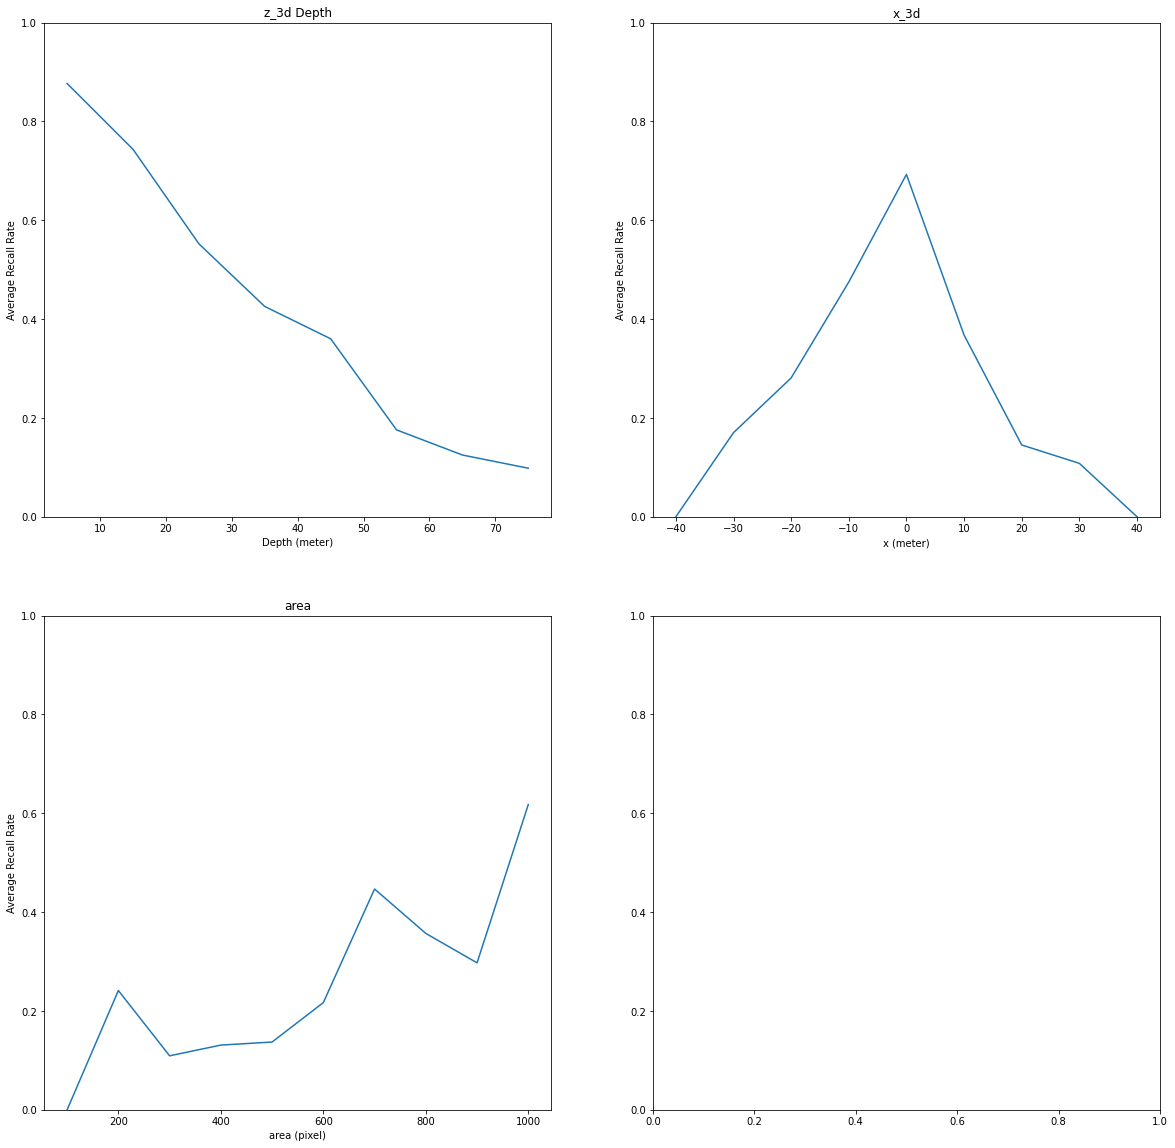

In [219]:


fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')
# plotting the points 
ax[0, 0].plot(z3d_bucket, z3d_values)
ax[0, 0].set_ylim([0, 1.0])
ax[0, 0].set_xlabel('Depth (meter)')
ax[0, 0].set_ylabel('Average Recall Rate')
ax[0, 0].set_title('z_3d Depth')
# 
ax[0, 1].plot(x3d_bucket, x3d_values)
ax[0, 1].set_ylim([0, 1.0])
ax[0, 1].set_xlabel('x (meter)')
ax[0, 1].set_ylabel('Average Recall Rate')
ax[0, 1].set_title('x_3d')
# 
ax[1, 0].plot(area_bucket, area_values)
ax[1, 0].set_ylim([0, 1.0])
ax[1, 0].set_xlabel('area (pixel)')
ax[1, 0].set_ylabel('Average Recall Rate')
ax[1, 0].set_title('area')
plt.show()

## Heatmap


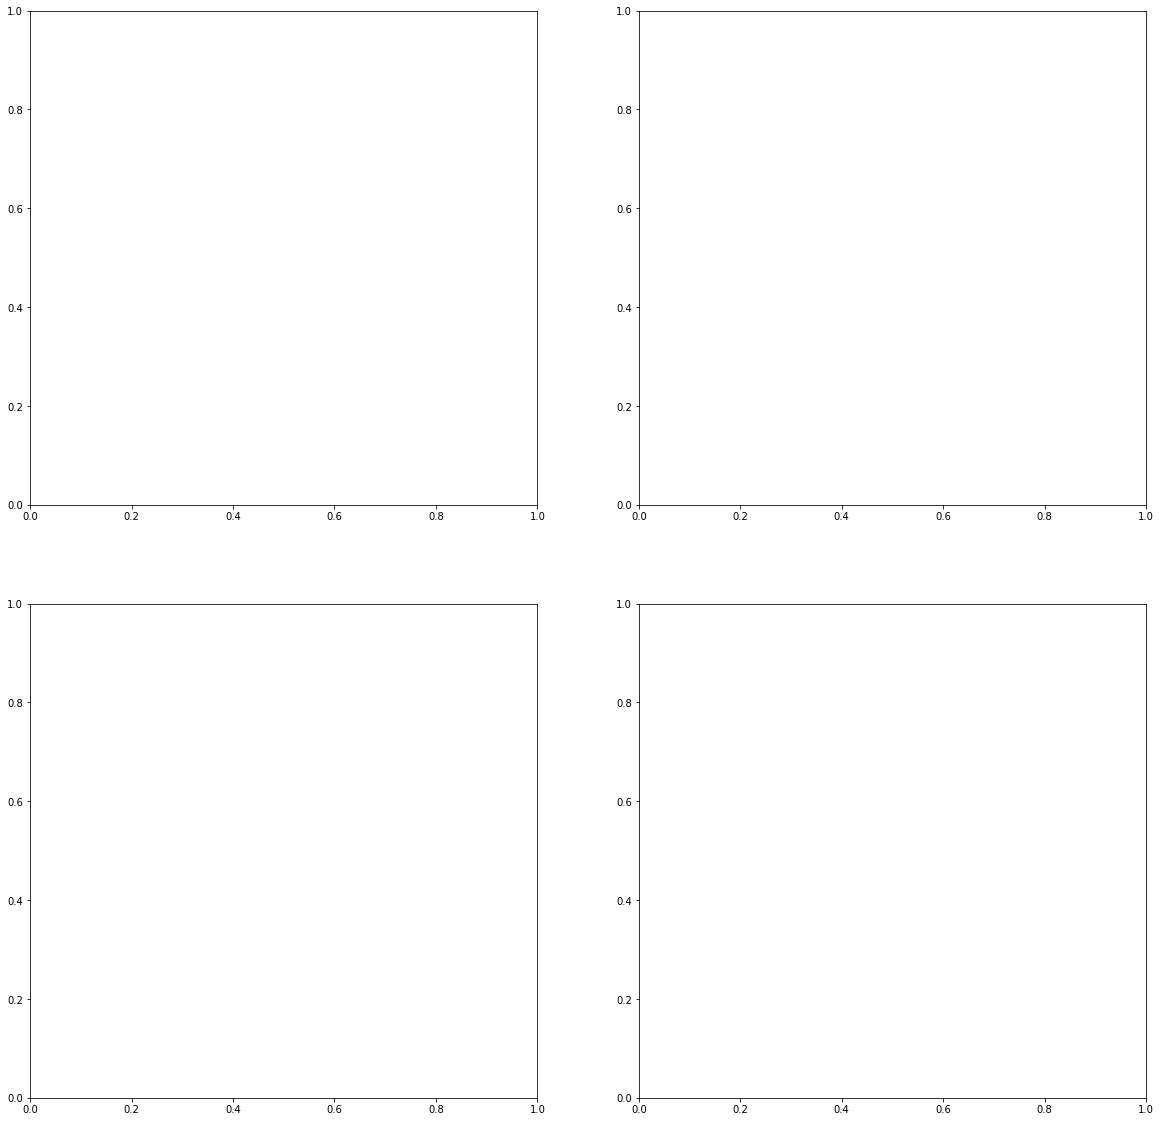

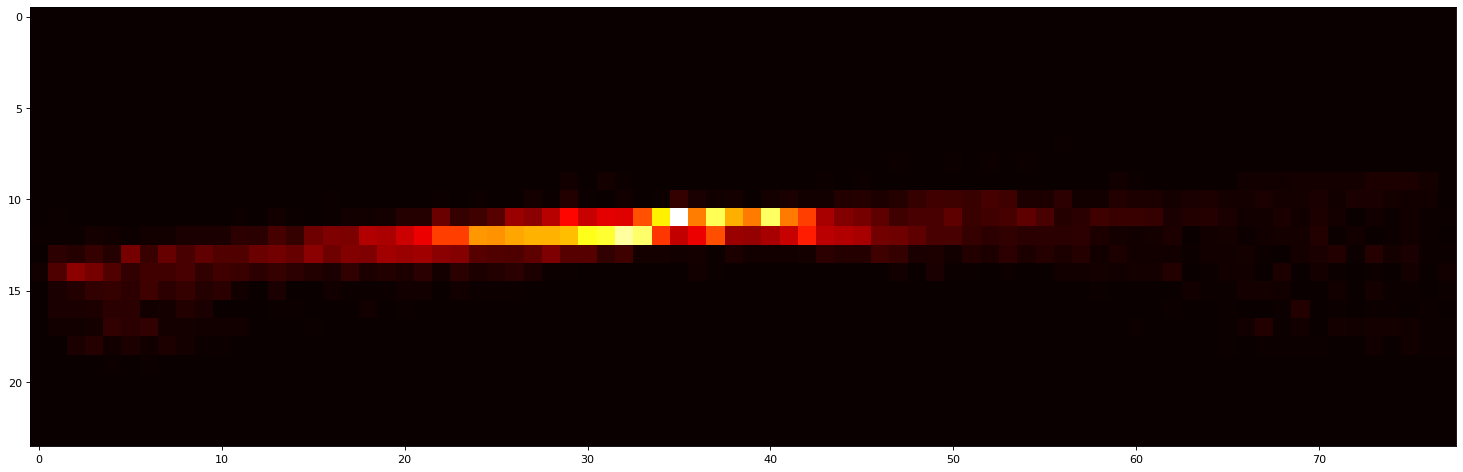

In [220]:
import matplotlib.pyplot as plt
import numpy as np
# 1242 x 375
DOWNSAMPLE_RATIO = 16
N_ROW =  375//DOWNSAMPLE_RATIO + 1
N_COL = 1242//DOWNSAMPLE_RATIO + 1

heat_data = np.zeros(shape=(N_ROW, N_COL))
for gt in gts_all:
    x, y = gt.center_2d

    # Output False negatives
    if len(gt.match['bev']) != 0 and gt.match['bev'][0][1] > IOU_THRES[0]: # Positive
        pass 
    else:
        # print((y//DOWNSAMPLE_RATIO, x//DOWNSAMPLE_RATIO))
        heat_data[int(y//DOWNSAMPLE_RATIO), int(x//DOWNSAMPLE_RATIO)] += 1 # 'fn'

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
fig.set_facecolor('white')

plt.figure(figsize=(375//DOWNSAMPLE_RATIO, 1242//DOWNSAMPLE_RATIO), dpi=80)
plt.imshow(heat_data, cmap='hot', interpolation='nearest')
# ax[0, 0] = imshow(heat_data, cmap='hot', interpolation='nearest')
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(cax=cax)
plt.show()
